<a href="https://colab.research.google.com/github/KAmbuske02/Pi-in-the-Sky/blob/main/Copy_of_Mobilenet_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>[Prerequisites (downloading tensorflow_models and checkpoints)](#scrollTo=T_cETKXHDTXu)

>[Checkpoint based inference](#scrollTo=fxMe7_pkk_Vo)

>[Frozen inference](#scrollTo=PlwvpK3ElBk6)



# Prerequisites (downloading tensorflow_models and checkpoints)

In [ ]:
!git clone https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 77698, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 77698 (delta 36), reused 37 (delta 18), pack-reused 77621
Receiving objects: 100% (77698/77698), 593.34 MiB | 31.96 MiB/s, done.
Resolving deltas: 100% (55195/55195), done.


In [ ]:
from __future__ import print_function
from IPython import display 
base_name = checkpoint_name = 'mobilenet_v2_1.0_224' #@param
url = 'https://storage.googleapis.com/mobilenet_v2/checkpoints/' + checkpoint_name + '.tgz'
print('Downloading from ', url)
!wget {url}
print('Unpacking')
!tar -xvf {checkpoint_name}.tgz
checkpoint = checkpoint_name + '.ckpt'

display.clear_output()
print('Successfully downloaded checkpoint from ', url,
      '. It is available as', checkpoint)


Successfully downloaded checkpoint from  https://storage.googleapis.com/mobilenet_v2/checkpoints/mobilenet_v2_1.0_224.tgz . It is available as mobilenet_v2_1.0_224.ckpt


In [ ]:
!wget https://upload.wikimedia.org/wikipedia/commons/f/fe/Giant_Panda_in_Beijing_Zoo_1.JPG -O panda.jpg
!wget https://ak.picdn.net/shutterstock/videos/1029080957/thumb/1.jpg -O tank.jpg
!wget https://www.armyrecognition.com/images/stories/north_america/united_states/main_battle_tank/m1a1_abrams/pictures1/M1A1_Abrams_main_battle_tank_US_United_States_army_defense_industry_military_technology_095.jpg -O sidetank.jpg
!wget https://thumbs.dreamstime.com/z/us-marines-marching-bucharest-romania-december-aerial-photo-united-states-soldiers-romania-s-national-day-military-63207644.jpg soldiers.jpg
!wget https://tse2.mm.bing.net/th?id=OIP.pO_nxCZ55VxeSWGk-g3ppgHaFj&pid=Api&P=0 -O sidesoldiers.jpg
!wget https://i.pinimg.com/originals/50/cd/da/50cdda81e9654361d0ac160e108d41fa.jpg -O boat.jpg
!wget http://3.bp.blogspot.com/_aN1IpfURBWo/SS9opn7Di3I/AAAAAAAAAQY/NgGM4MyltqE/w1200-h630-p-k-no-nu/bb32.jpg -O bwboat.jpg

--2022-09-30 20:30:44--  https://upload.wikimedia.org/wikipedia/commons/f/fe/Giant_Panda_in_Beijing_Zoo_1.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116068 (113K) [image/jpeg]
Saving to: ‘panda.jpg’

panda.jpg           100%[===================>] 113.35K  --.-KB/s    in 0.03s   

2022-09-30 20:30:45 (3.72 MB/s) - ‘panda.jpg’ saved [116068/116068]

--2022-09-30 20:30:45--  https://ak.picdn.net/shutterstock/videos/1029080957/thumb/1.jpg
Resolving ak.picdn.net (ak.picdn.net)... 108.157.162.126, 108.157.162.21, 108.157.162.82, ...
Connecting to ak.picdn.net (ak.picdn.net)|108.157.162.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87016 (85K) [image/jpeg]
Saving to: ‘tank.jpg’

tank.jpg            100%[===================>]  84.98K  --.-KB/s    in 0.03s   

2022

In [ ]:
# setup path and install tf-slim
import sys
sys.path.append('/content/models/research/slim')
!pip install tf_slim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 352 kB 5.2 MB/s 


# Checkpoint based inference

In [ ]:
import tensorflow.compat.v1 as tf
import tf_slim as slim
from nets.mobilenet import mobilenet_v2

tf.compat.v1.disable_eager_execution()
tf.reset_default_graph()

# For simplicity we just decode jpeg inside tensorflow.
# But one can provide any input obviously.
file_input = tf.placeholder(tf.string, ())

image = tf.image.decode_jpeg(tf.read_file(file_input))

images = tf.expand_dims(image, 0)
images = tf.cast(images, tf.float32) / 128.  - 1
images.set_shape((None, None, None, 3))
images = tf.image.resize_images(images, (224, 224))

# Note: arg_scope is optional for inference.
with slim.arg_scope(mobilenet_v2.training_scope(is_training=False)):
  logits, endpoints = mobilenet_v2.mobilenet(images)
  
# Restore using exponential moving average since it produces (1.5-2%) higher 
# accuracy
ema = tf.train.ExponentialMovingAverage(0.999)
vars = ema.variables_to_restore()

saver = tf.train.Saver(vars)  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


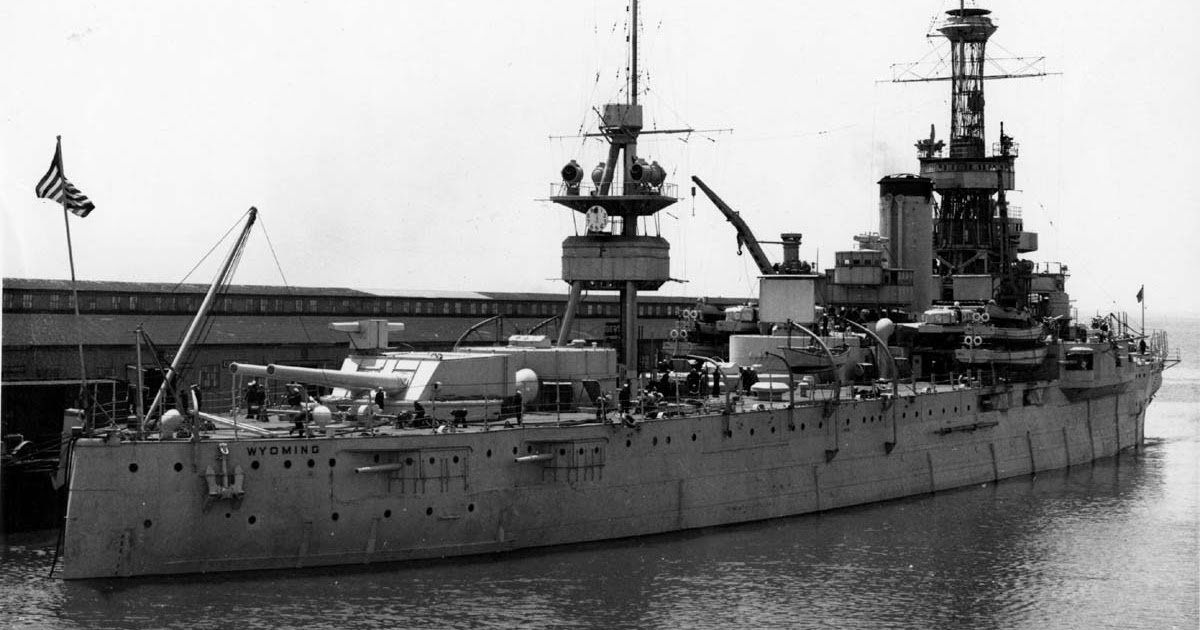

Top 1 prediction:  404 aircraft carrier, carrier, flattop, attack aircraft carrier 0.28691968


In [ ]:
from IPython import display
import pylab
from datasets import imagenet
import PIL
display.display(display.Image('bwboat.jpg'))

with tf.Session() as sess:
  saver.restore(sess,  checkpoint)
  x = endpoints['Predictions'].eval(feed_dict={file_input: 'bwboat.jpg'})
label_map = imagenet.create_readable_names_for_imagenet_labels()  
print("Top 1 prediction: ", x.argmax(),label_map[x.argmax()], x.max())


# Frozen inference

In [ ]:
import numpy as np
img = np.array(PIL.Image.open('panda.jpg').resize((224, 224))).astype(np.float) / 128 - 1
gd = tf.GraphDef.FromString(open(checkpoint_name + '_frozen.pb', 'rb').read())
inp, predictions = tf.import_graph_def(gd,  return_elements = ['input:0', 'MobilenetV2/Predictions/Reshape_1:0'])

In [ ]:
with tf.Session(graph=inp.graph):
  x = predictions.eval(feed_dict={inp: img.reshape(1, 224,224, 3)})

label_map = imagenet.create_readable_names_for_imagenet_labels()  
print("Top 1 Prediction: ", x.argmax(),label_map[x.argmax()], x.max())

Top 1 Prediction:  389 giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca 0.9220208
